In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import Ridge

         t          R          J
0    0.001  -1.678969   3.635587
1    0.002  -1.331200   1.092044
2    0.003  -3.262655   2.606360
3    0.004   0.747600   2.653503
4    0.005  -2.595587   2.486163
..     ...        ...        ...
995  0.996 -53.217953 -39.477531
996  0.997 -52.431048 -39.574062
997  0.998 -54.473581 -40.486137
998  0.999 -54.210126 -39.670725
999  1.000 -53.957241 -40.705642

[1000 rows x 3 columns]


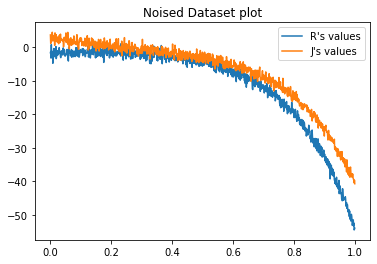

In [ ]:
# Don't forget to upload exact.xlsx file onto this colab notebook

df = pd.read_excel("exact.xlsx")
df.rename(columns = {str(df.columns[0]): "t"}, inplace = True)
df.eval("t = t + 1", inplace = True)
df.eval("t = t * 0.001", inplace = True)

# Print data table
print(df)

# Plot data
plt.plot(df.iloc[:, 0], df.iloc[:, 1:3])
plt.legend(["R's values", "J's values"])
plt.title("Noised Dataset plot")
plt.savefig("5_Vi_1")

# Change data to numpy type
data = df.to_numpy()
t = data[:, 0]
R = data[:, 1]
J = data[:, 2]

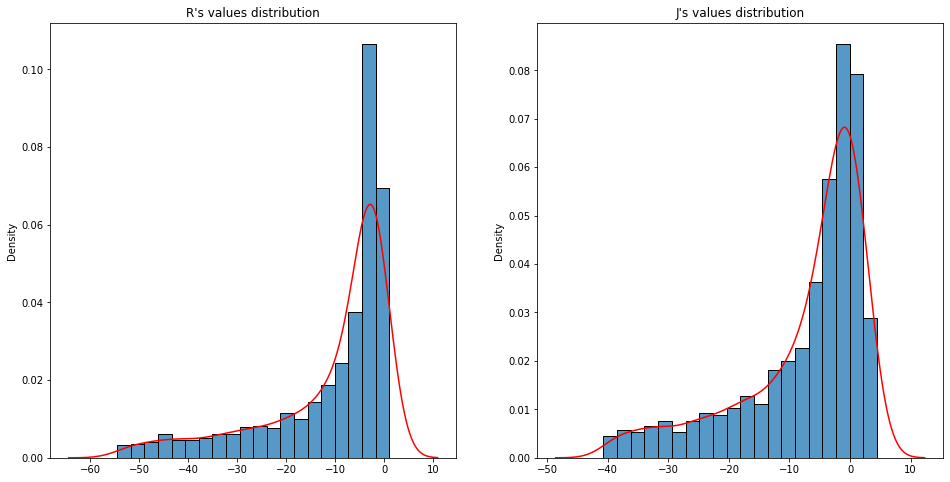

In [ ]:
import seaborn as sns
fig, axes = plt.subplots(1, 2, figsize = (16, 8))
sns.histplot(data=R, bins = 20, stat = 'density', ax = axes[0])
sns.kdeplot(data=R, color = 'red', ax = axes[0])
axes[0].set_title("R's values distribution")

sns.histplot(data=J, bins = 20, stat = 'density', ax = axes[1])
sns.kdeplot(data=J, color = 'red', ax = axes[1])
axes[1].set_title("J's values distribution")

plt.savefig("5_Vi_2")

In [ ]:
# Euler method for approximating
def Forward_Euler(R_0, J_0, W, h):
  a = W[0, 0]
  b = W[1, 0]
  c = W[2, 0]
  d = W[3, 0]

  R_pred = [R_0]
  J_pred = [J_0]
  for i in range(1000):
    R_st = R_pred[len(R_pred) - 1]
    J_st = J_pred[len(J_pred) - 1]
    R_nd = R_st + (a * R_st + b * J_st) * h
    J_nd = J_st + (c * R_st + d * J_st) * h
    R_pred.append(R_nd)
    J_pred.append(J_nd)
  return R_pred, J_pred

# Data denoising method

R's STD: 0.9939919413406086
J's STD: 0.957500078425086
[[ 2.17814695]
 [ 3.75598744]
 [ 5.65972833]
 [-2.55294712]]
1.8871889827072692


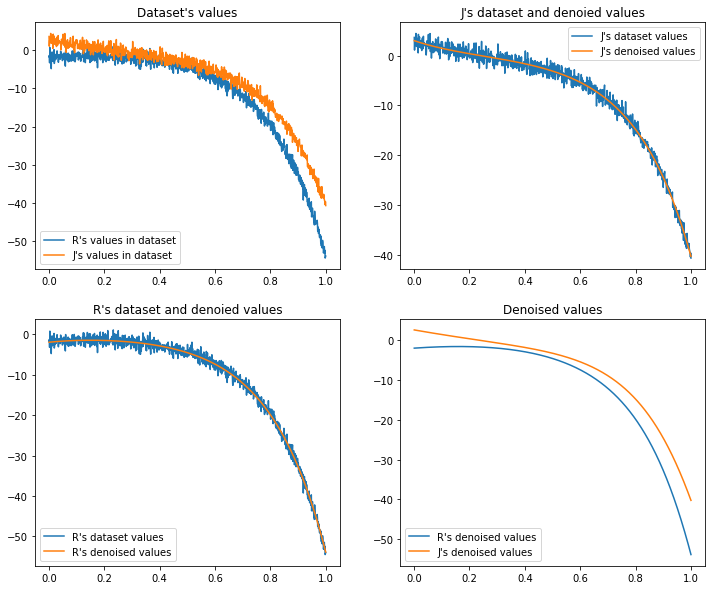

In [ ]:
fig, axes = plt.subplots(2, 2, figsize = (12, 10))
axes[0, 0].plot(t, R)
axes[0, 0].plot(t, J)
axes[0, 0].legend(["R's values in dataset", "J's values in dataset"])
axes[0, 0].set_title("Dataset's values")


# Data denoising
t_feature = np.vander(t, 20)
denoiser = BayesianRidge(tol=1e-6, fit_intercept=False, compute_score=True)
denoiser.set_params(alpha_init = 1.0, lambda_init = 0.001)
denoiser.fit(t_feature, R)
R_mean, R_std = denoiser.predict(t_feature, return_std = True)

denoiser.fit(t_feature, J)
J_mean, J_std = denoiser.predict(t_feature, return_std = True)

print(f"R's STD: {np.mean(R_std)}")
print(f"J's STD: {np.mean(J_std)}")

# Plot solutions
axes[1, 1].plot(t, R_mean)
axes[1, 1].plot(t, J_mean)
axes[1, 1].legend(["R's denoised values", "J's denoised values"])
axes[1, 1].set_title("Denoised values")

# Calculate derivative
R_ = [(R_mean[0] + 2) / 0.001]
J_ = [(J_mean[0] - 3) / 0.001]
for i in range(1, 1000, 1):
  R_.append((R_mean[i] - R_mean[i - 1]) / 0.001)
  J_.append((J_mean[i] - J_mean[i - 1]) / 0.001)

# Estimate coefs
reg = LinearRegression()
train_size = 540
X = np.hstack([R_mean.reshape(-1, 1), J_mean.reshape(-1, 1)])
reg.fit(X[:train_size, :], R_[:train_size])
reg_W = reg.coef_
reg.fit(X[:train_size, :], J_[:train_size])
reg_W = np.hstack([reg_W, reg.coef_]).reshape(-1, 1)

# Print coefs
print(reg_W)

# Print error
R_pred, J_pred = Forward_Euler(-2, 3, reg_W, 0.001)
print(np.mean((R_pred[1: ] - R) ** 2 + (J_pred[1: ] - J) ** 2))

# Compare
axes[1, 0].plot(t, R)
axes[1, 0].plot(t, R_pred[1: ])
axes[1, 0].legend(["R's dataset values", "R's denoised values"])
axes[1, 0].set_title("R's dataset and denoied values")

axes[0, 1].plot(t, J)
axes[0, 1].plot(t, J_pred[1: ])
axes[0, 1].legend(["J's dataset values", "J's denoised values"])
axes[0, 1].set_title("J's dataset and denoied values")

plt.savefig("5_Vi_3")

# Gradient Descent method

[[ 2.18850506]
 [ 3.71202328]
 [ 5.63099147]
 [-2.5319269 ]]
Mean Squared Error: 1.8945104355414206


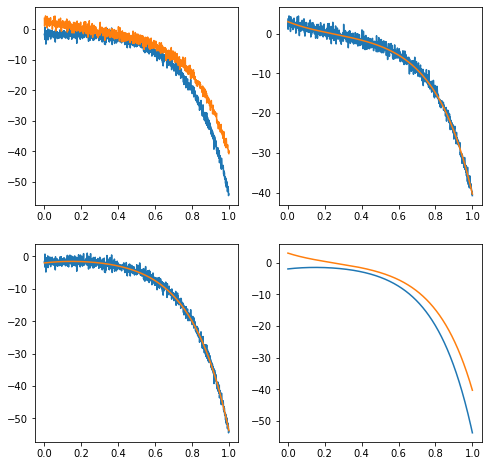

In [ ]:
fig, axes = plt.subplots(2, 2, figsize = (8, 8))
axes[0, 0].plot(t, R)
axes[0, 0].plot(t, J)

# Gradient descent
W = np.array([0.0, 0.0, 0.0, 0.0]).reshape(-1, 1)
losses = []

for i in range(5000):
  R_pred, J_pred = Forward_Euler(-2, 3, W, 0.001)
  sum = np.array([0.0, 0.0, 0.0, 0.0]).reshape(-1, 1)
  loss = 0
  for j in range(1, 1000, 1):
    X1 = np.array([R_pred[j - 1], J_pred[j - 1], 0.0, 0.0]).reshape(-1, 1)
    X2 = np.array([0.0, 0.0, R_pred[j - 1], J_pred[j - 1]]).reshape(-1, 1)
    sum += X1 * 0.001 * (R_pred[j - 1] + (np.transpose(W)).dot(X1) * 0.001 - R[j - 1])
    sum += X2 * 0.001 * (J_pred[j - 1] + (np.transpose(W)).dot(X2) * 0.001 - J[j - 1])
    loss += (R_pred[j] - R[j - 1]) ** 2 + (J_pred[j] - J[j - 1]) ** 2
  sum /= 999
  losses.append(loss / 999)
  W -= 4 * sum

# Print coefs and error
print(W)
print(f'Mean Squared Error: {np.min(losses)}')

# Plot solutions
R_final, J_final = Forward_Euler(-2, 3, W, 0.001)
axes[1, 1].plot(np.linspace(0, 1, 1001), R_final)
axes[1, 1].plot(np.linspace(0, 1, 1001), J_final)

axes[1, 0].plot(t, R)
axes[1, 0].plot(t, R_final[1: ])

axes[0, 1].plot(t, J)
axes[0, 1].plot(t, J_final[1: ])

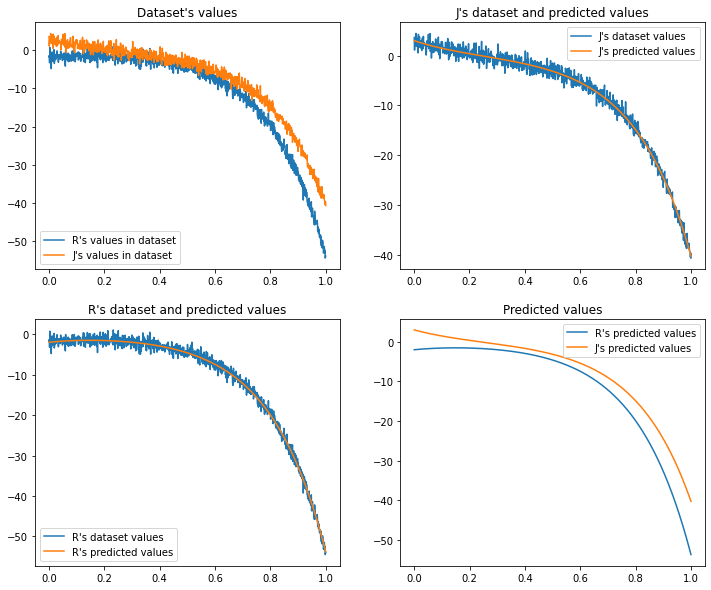

In [ ]:
fig, axes = plt.subplots(2, 2, figsize = (12, 10))
axes[0, 0].plot(t, R)
axes[0, 0].plot(t, J)
axes[0, 0].legend(["R's values in dataset", "J's values in dataset"])
axes[0, 0].set_title("Dataset's values")

R_final, J_final = Forward_Euler(-2, 3, W, 0.001)
axes[1, 1].plot(np.linspace(0, 1, 1001), R_final)
axes[1, 1].plot(np.linspace(0, 1, 1001), J_final)
axes[1, 1].legend(["R's predicted values", "J's predicted values"])
axes[1, 1].set_title("Predicted values")

axes[1, 0].plot(t, R)
axes[1, 0].plot(t, R_final[1: ])
axes[1, 0].legend(["R's dataset values", "R's predicted values"])
axes[1, 0].set_title("R's dataset and predicted values")

axes[0, 1].plot(t, J)
axes[0, 1].plot(t, J_final[1: ])
axes[0, 1].legend(["J's dataset values", "J's predicted values"])
axes[0, 1].set_title("J's dataset and predicted values")

plt.savefig("5_Vi_4")

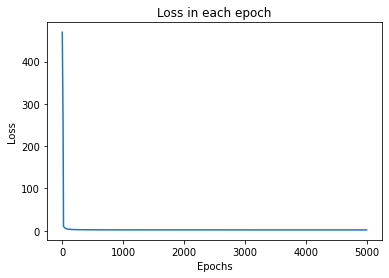

In [ ]:
plt.plot(np.arange(5000), losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss in each epoch")
plt.savefig("5_Vi_5")

# Time series method